# Data retieval

The data used is stored inside this google drive. However, should this not be accessible then the code below will be used instead. The data to be used must be uploaded to the colab session and stored in "/content/data/stance/..."

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/AML - Assessment 2/stance/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Code below is for manual data upload:

In [ ]:
base_path = "/content/data/stance/"

The data is read into "data_dict". Example:

data_dict["abortion_test_labels"]

In [ ]:
base_test_labels = "/test_labels.txt"
base_test_text = "/test_text.txt"
base_train_labels = "/train_labels.txt"
base_train_text = "/train_text.txt"
base_val_labels = "/val_labels.txt"
base_val_text = "/val_text.txt"

topics = ["abortion","atheism","climate","feminist","hillary"]
data_dict = {}

for topic in topics:
  for i in range(6):
    temp_data = []
    cleaned_data = []
    if i == 0:
      path = base_path + topic + base_test_labels
      name = "_test_labels"
    if i == 1:
      path = base_path + topic + base_test_text
      name = "_test_text"
    if i == 2:
      path = base_path + topic + base_train_labels
      name = "_train_labels"
    if i == 3:
      path = base_path + topic + base_train_text
      name = "_train_text"
    if i == 4:
      path = base_path + topic + base_val_labels
      name = "_val_labels"
    if i == 5:
      path = base_path + topic + base_val_text
      name = "_val_text"

    with open(path, encoding="utf8", errors='ignore') as f:
      temp_data.append(f.readlines())
      #print(temp_data)

      #REMOVE "\n" FROM END OF DATA ENTRY
      for data in temp_data[0]:
        cleaned_data.append(data.strip('\n'))
    
      data_dict[(topic +  name)] = (cleaned_data)


In [ ]:
print(data_dict.keys())
print(data_dict["abortion_test_text"])
print(data_dict["abortion_test_labels"])

# Data Preprocessing

Tokensize + Lowercase all tweets

Results stored in "*data_dict_tokenized*"

In [ ]:
import nltk
import string
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

all_tweets = []
all_tokens = []
lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stopwords=set(nltk.corpus.stopwords.words('english'))
# We can add more words to the stopword list, like punctuation marks
new_stopwords = [".", ",", "--", "``","''","'s","ha","wa","mr","#SemST","!"]
stopwords = stopwords.union(new_stopwords) 
#print(stopwords)

data_dict_cleaned = {}

for key in data_dict:
  if "label" not in key:
    all_tweets = []
    for tweet in data_dict[key]:
      tweet_tokens = []
      #print("Tweet: ", tweet)
      sentence_split = nltk.tokenize.sent_tokenize(str(tweet))
      for sentence in sentence_split:
        list_tokens_sentence = nltk.tokenize.word_tokenize(sentence)
        for token in list_tokens_sentence:
          #print("tokens: ",token)
          if token not in stopwords: tweet_tokens.append(lemmatizer.lemmatize(token.lower()))
        
      all_tweets.append(tweet_tokens)

    data_dict_cleaned[key] = all_tweets
  else:
    all_tokens = []
    for label in data_dict[key]:
      all_tokens.append(int(label))
    data_dict_cleaned[key] = all_tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
indice_dict_pos = {}
indice_dict_neg = {}
indice_dict_neither = {}



for key in data_dict:
  temp_pos = []
  temp_neg = []
  temp_neither = []
  i = 0
  if "label" in key:
    for line in data_dict[key]:
      if int(line) == 0:
        temp_neither.append(i)
      if int(line) == 1:
        temp_neg.append(i)
      if int(line) == 2:
        temp_pos.append(i)
        

      i += 1

    indice_dict_neither[key] = temp_neither
    indice_dict_neg[key] = temp_neg
    indice_dict_pos[key] = temp_pos


# SVM Baselines

## SVM Baseline: Unigrams feature creation

Final feature stored in dictionary: "*data_dict_unigrams*"

In [ ]:
import numpy as np
import nltk
import string
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

all_tweets = []
all_tokens = []
lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stopwords=set(nltk.corpus.stopwords.words('english'))

data_dict_tokenized = {}

for key in data_dict:
  if "label" not in key:
    all_tweets = []
    for tweet in data_dict[key]:
      tweet_tokens = []
      #print("Tweet: ", tweet)
      sentence_split = nltk.tokenize.sent_tokenize(str(tweet))
      for sentence in sentence_split:
        list_tokens_sentence = nltk.tokenize.word_tokenize(sentence)
        for token in list_tokens_sentence:
          #print("tokens: ",token)
          tweet_tokens.append(lemmatizer.lemmatize(token.lower()))
        
      all_tweets.append(tweet_tokens)

    data_dict_tokenized[key] = all_tweets
  else:
    all_tokens = []
    for label in data_dict[key]:
      all_tokens.append(int(label))
    data_dict_tokenized[key] = all_tokens

#TURN IT INTO A BAG OF WORDS VECTOR REPRESENTATION
count_vector = CountVectorizer(input='content',decode_error='ignore',
                               stop_words=stopwords, 
                               max_features=10000,
                               analyzer=lambda x: x)
data_dict_unigrams_1 = {}


#Combine train, test and val sets, use "count_vector" to turn them in to BOW representation
#, normalise them and seperate ready for training.
for topic in ["abortion","atheism","feminist","climate","hillary"]:
  all_topic_text = data_dict_tokenized[topic+"_train_text"] + data_dict_tokenized[topic+"_test_text"] + data_dict_tokenized[topic+"_val_text"]

  len_train = len(data_dict_tokenized[topic+"_train_text"])
  len_test = len(data_dict_tokenized[topic+"_test_text"])
  len_val = len(data_dict_tokenized[topic+"_val_text"])

  vector_all_text = count_vector.fit_transform(all_topic_text)
  tfidf_transformer = TfidfTransformer().fit(vector_all_text) #By default this is using the 'l2' norm
  vector_all_text_normalised = tfidf_transformer.transform(vector_all_text).toarray()

  data_dict_unigrams_1[topic+"_train_text"] = vector_all_text_normalised[0:len_train]
  data_dict_unigrams_1[topic+"_test_text"] = vector_all_text_normalised[len_train:len_train+len_test]
  data_dict_unigrams_1[topic+"_val_text"] = vector_all_text_normalised[len_train+len_test:]


for key in data_dict_tokenized:
  if "labels" in key:
    data_dict_unigrams_1[key] = np.asarray(data_dict_tokenized[key])
    



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(data_dict_unigrams_1["climate_test_labels"])

[0 2 2 0 2 2 2 2 0 2 2 0 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2
 2 0 2 2 2 0 2 2 2 0 2 2 0 0 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 0 1 2 2 0 2 2 2 2 2 2 1 0
 0 2 0 0 2 2 0 0 2 1 2 0 2 2 2 2 1 2 2 2 2 0 2 2 0 1 2 2 2 2 2 2 2 2 1 1 1
 2 1 2 1 2 2 2 0 2 1 2 2 2 0 0 0 0 2 2 2 2]


## SVM Baselines: Uni/Bi/Trigrams feature creation

Final feature stored in dictionary: "*data_dict_ngrams*"

In [ ]:
import nltk
import string
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


all_tokens = []
lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

data_dict_tokenized = {}
data_dict_unigrams = {}
data_dict_bigrams = {}
data_dict_trigrams = {}
data_dict_char_2grams = {}
data_dict_char_3grams = {}
data_dict_char_4grams = {}
data_dict_char_5grams = {}

for key in data_dict:
  #print(key)
  all_tweets_unigram = []
  all_tweets_bigram = []
  all_tweets_trigram = []
  all_tweets_char_2gram = []
  all_tweets_char_3gram = []
  all_tweets_char_4gram = []
  all_tweets_char_5gram = []
  if "label" not in key:
    all_tweets = []
    for tweet in data_dict[key]:
      tweet_tokens_unigram = []
      tweet_tokens_bigram = []
      tweet_tokens_trigram = []
      char_tokens_2gram = []
      char_tokens_3gram = []
      char_tokens_4gram = []
      char_tokens_5gram = []
      #print("Tweet: ", tweet)
      sentence_split = nltk.tokenize.sent_tokenize(str(tweet))
      for sentence in sentence_split:
        list_tokens_sentence = nltk.tokenize.word_tokenize(sentence)
        for i, token in enumerate(list_tokens_sentence):
          #UNIGRAM
          tweet_tokens_unigram.append(lemmatizer.lemmatize(token.lower()))
          #BIGRAM
          if i >= 1:
            pair = list_tokens_sentence[i-1] + " " + list_tokens_sentence[i]
            tweet_tokens_bigram.append(lemmatizer.lemmatize(pair.lower()))
          #TRIGRAM
          if i >= 2:
            triple = list_tokens_sentence[i-2] + " " + list_tokens_sentence[i-1] + " " + list_tokens_sentence[i]
            tweet_tokens_trigram.append(lemmatizer.lemmatize(triple.lower()))
          #CHARACTER N-GRAMS
          for i, character in enumerate(token):
            if i >= 1:
              char_tokens_2gram.append(token[i-1]+token[i])
            if i >= 2:
              char_tokens_3gram.append(token[i-2]+token[i-1]+token[i])
            if i >= 3:
              char_tokens_4gram.append(token[i-3]+token[i-2]+token[i-1]+token[i])
            if i >= 4:
              char_tokens_5gram.append(token[i-4]+token[i-3]+token[i-2]+token[i-1]+token[i])


        
      all_tweets_unigram.append(tweet_tokens_unigram)
      all_tweets_bigram.append(tweet_tokens_bigram)
      all_tweets_trigram.append(tweet_tokens_trigram)
      all_tweets_char_2gram.append(char_tokens_2gram)
      all_tweets_char_3gram.append(char_tokens_3gram)
      all_tweets_char_4gram.append(char_tokens_4gram)
      all_tweets_char_5gram.append(char_tokens_5gram)

    data_dict_unigrams[key]  = all_tweets_unigram
    data_dict_bigrams[key]  = all_tweets_bigram
    data_dict_trigrams[key]  = all_tweets_trigram
    data_dict_char_2grams[key]  = all_tweets_char_2gram
    data_dict_char_3grams[key]  = all_tweets_char_3gram
    data_dict_char_4grams[key]  = all_tweets_char_4gram
    data_dict_char_5grams[key]  = all_tweets_char_5gram
  else:
    all_tokens = []
    for label in data_dict[key]:
      all_tokens.append(int(label))
    data_dict_tokenized[key] = all_tokens



#TURN IT INTO A BAG OF WORDS VECTOR REPRESENTATION
count_vector = CountVectorizer(input='content',decode_error='ignore',
                               stop_words=stopwords, 
                               max_features=1000,
                               analyzer=lambda x: x)

data_dict_ngrams = {}
data_dict_unigrams_vector = {}
data_dict_bigrams_vector = {}
data_dict_trigrams_vector = {}
data_dict_char_2grams_vector = {}
data_dict_char_3grams_vector = {}
data_dict_char_4grams_vector = {}
data_dict_char_5grams_vector = {}

#Combine train, test and val sets, use "count_vector" to turn them in to BOW representation
#, normalise them and seperate ready for training.
for topic in ["abortion","atheism","feminist","climate","hillary"]:
  all_topic_text_unigrams = data_dict_unigrams[topic+"_train_text"] + data_dict_unigrams[topic+"_test_text"] + data_dict_unigrams[topic+"_val_text"]
  all_topic_text_bigrams = data_dict_bigrams[topic+"_train_text"] + data_dict_bigrams[topic+"_test_text"] + data_dict_bigrams[topic+"_val_text"]
  all_topic_text_trigrams = data_dict_trigrams[topic+"_train_text"] + data_dict_trigrams[topic+"_test_text"] + data_dict_trigrams[topic+"_val_text"]
  all_topic_text_char_2grams = data_dict_char_2grams[topic+"_train_text"] + data_dict_char_2grams[topic+"_test_text"] + data_dict_char_2grams[topic+"_val_text"]
  all_topic_text_char_3grams = data_dict_char_3grams[topic+"_train_text"] + data_dict_char_3grams[topic+"_test_text"] + data_dict_char_3grams[topic+"_val_text"]
  all_topic_text_char_4grams = data_dict_char_4grams[topic+"_train_text"] + data_dict_char_4grams[topic+"_test_text"] + data_dict_char_4grams[topic+"_val_text"]
  all_topic_text_char_5grams = data_dict_char_5grams[topic+"_train_text"] + data_dict_char_5grams[topic+"_test_text"] + data_dict_char_5grams[topic+"_val_text"]

  len_train = len(data_dict_unigrams[topic+"_train_text"])
  len_test = len(data_dict_unigrams[topic+"_test_text"])
  len_val = len(data_dict_unigrams[topic+"_val_text"])

  #UNIGRAMS
  vector_all_text = count_vector.fit_transform(all_topic_text_unigrams)
  tfidf_transformer = TfidfTransformer().fit(vector_all_text) #By default this is using the 'l2' norm
  unigrams_vector = tfidf_transformer.transform(vector_all_text).toarray()

  data_dict_unigrams_vector[topic+"_train_text"] = unigrams_vector[0:len_train]
  data_dict_unigrams_vector[topic+"_test_text"] = unigrams_vector[len_train:len_train+len_test]
  data_dict_unigrams_vector[topic+"_val_text"] = unigrams_vector[len_train+len_test:]

  #BIGRAMS
  vector_all_text = count_vector.fit_transform(all_topic_text_bigrams)
  tfidf_transformer = TfidfTransformer().fit(vector_all_text) #By default this is using the 'l2' norm
  bigrams_vector = tfidf_transformer.transform(vector_all_text).toarray()

  data_dict_bigrams_vector[topic+"_train_text"] = bigrams_vector[0:len_train]
  data_dict_bigrams_vector[topic+"_test_text"] = bigrams_vector[len_train:len_train+len_test]
  data_dict_bigrams_vector[topic+"_val_text"] = bigrams_vector[len_train+len_test:]

  #TRIGRAMS
  vector_all_text = count_vector.fit_transform(all_topic_text_trigrams)
  tfidf_transformer = TfidfTransformer().fit(vector_all_text) #By default this is using the 'l2' norm
  trigrams_vector = tfidf_transformer.transform(vector_all_text).toarray()

  data_dict_trigrams_vector[topic+"_train_text"] = trigrams_vector[0:len_train]
  data_dict_trigrams_vector[topic+"_test_text"] = trigrams_vector[len_train:len_train+len_test]
  data_dict_trigrams_vector[topic+"_val_text"] = trigrams_vector[len_train+len_test:]

  #CHAR_2GRAMS
  vector_all_text = count_vector.fit_transform(all_topic_text_char_2grams)
  tfidf_transformer = TfidfTransformer().fit(vector_all_text) #By default this is using the 'l2' norm
  char_2grams_vector = tfidf_transformer.transform(vector_all_text).toarray()

  data_dict_char_2grams_vector[topic+"_train_text"] = char_2grams_vector[0:len_train]
  data_dict_char_2grams_vector[topic+"_test_text"] = char_2grams_vector[len_train:len_train+len_test]
  data_dict_char_2grams_vector[topic+"_val_text"] = char_2grams_vector[len_train+len_test:]

  #CHAR_3GRAMS
  vector_all_text = count_vector.fit_transform(all_topic_text_char_3grams)
  tfidf_transformer = TfidfTransformer().fit(vector_all_text) #By default this is using the 'l2' norm
  char_3grams_vector = tfidf_transformer.transform(vector_all_text).toarray()

  data_dict_char_3grams_vector[topic+"_train_text"] = char_3grams_vector[0:len_train]
  data_dict_char_3grams_vector[topic+"_test_text"] = char_3grams_vector[len_train:len_train+len_test]
  data_dict_char_3grams_vector[topic+"_val_text"] = char_3grams_vector[len_train+len_test:]

  #CHAR_4GRAMS
  vector_all_text = count_vector.fit_transform(all_topic_text_char_4grams)
  tfidf_transformer = TfidfTransformer().fit(vector_all_text) #By default this is using the 'l2' norm
  char_4grams_vector = tfidf_transformer.transform(vector_all_text).toarray()

  data_dict_char_4grams_vector[topic+"_train_text"] = char_4grams_vector[0:len_train]
  data_dict_char_4grams_vector[topic+"_test_text"] = char_4grams_vector[len_train:len_train+len_test]
  data_dict_char_4grams_vector[topic+"_val_text"] = char_4grams_vector[len_train+len_test:]

  #CHAR_5GRAMS
  vector_all_text = count_vector.fit_transform(all_topic_text_char_5grams)
  tfidf_transformer = TfidfTransformer().fit(vector_all_text) #By default this is using the 'l2' norm
  char_5grams_vector = tfidf_transformer.transform(vector_all_text).toarray()

  data_dict_char_5grams_vector[topic+"_train_text"] = char_5grams_vector[0:len_train]
  data_dict_char_5grams_vector[topic+"_test_text"] = char_5grams_vector[len_train:len_train+len_test]
  data_dict_char_5grams_vector[topic+"_val_text"] = char_5grams_vector[len_train+len_test:]


print("Final dimensions of feature: ")
for key in data_dict:
  if "label" not in key:
    data_dict_ngrams[key] = np.concatenate((data_dict_unigrams_vector[key],
                                            data_dict_bigrams_vector[key],
                                            data_dict_trigrams_vector[key],
                                            data_dict_char_2grams_vector[key],
                                            data_dict_char_3grams_vector[key],
                                            data_dict_char_4grams_vector[key],
                                            data_dict_char_5grams_vector[key]),
                                           axis = 1)
    print(key, ": ", data_dict_ngrams[key].shape)
  else:
    data_dict_ngrams[key] = np.asarray(data_dict_tokenized[key])
    print(key, ": ", data_dict_ngrams[key].shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Final dimensions of feature: 
abortion_test_labels :  (280,)
abortion_test_text :  (280, 7000)
abortion_train_labels :  (587,)
abortion_train_text :  (587, 7000)
abortion_val_labels :  (66,)
abortion_val_text :  (66, 7000)
atheism_test_labels :  (220,)
atheism_test_text :  (220, 7000)
atheism_train_labels :  (461,)
atheism_train_text :  (461, 7000)
atheism_val_labels :  (52,)
atheism_val_text :  (52, 7000)
climate_test_labels :  (169,)
climate_test_text :  (169, 7000)
climate_train_labels :  (355,)
climate_train_text :  (355, 7000)
climate_val_labels :  (40,)
climate_val_text :  (40, 7000)
feminist_test_labels :  (285,)
feminist_test_text :  (285,

## SVM Baseline Models

In [ ]:
import numpy as np
import sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

stopwords=set(nltk.corpus.stopwords.words('english'))


def train_SVM(X_train,Y_train, X_test, Y_test):
    model = sklearn.svm.SVC(kernel="linear",gamma="auto")
    model.fit(X_train, Y_train)
    accuracy, report = test_SVM(model, X_test, Y_test)

    return model, accuracy, report

def test_SVM(model, X_test, Y_test):
    predictions = model.predict(X_test)
    accuracy=accuracy_score(Y_test, predictions)
    report = classification_report(Y_test, predictions)
    #print ("Accuracy: "+str(round(accuracy,3)))
    return accuracy, report

In [ ]:
for topic in ["abortion", "atheism","climate","feminist","hillary"]:
  positive_text = []
  positive_labels = []
  negative_text = []
  negative_labels = []
  neither_text = []
  neither_labels = []


  for i, x in enumerate(data_dict_unigrams_1[topic+"_test_labels"]):
    if x == 1:
      negative_text.append(data_dict_unigrams_1[topic+"_test_text"][i])
      negative_labels.append(data_dict_unigrams_1[topic+"_test_labels"][i])
    if x== 2:
      positive_text.append(data_dict_unigrams_1[topic+"_test_text"][i])
      positive_labels.append(data_dict_unigrams_1[topic+"_test_labels"][i])
    if x == 0:
      neither_text.append(data_dict_unigrams_1[topic+"_test_text"][i])
      neither_labels.append(data_dict_unigrams_1[topic+"_test_labels"][i])
      
  x_negative = np.asarray(negative_text)
  y_negative = np.asarray(negative_labels)

  x_positive = np.asarray(positive_text)
  y_positive = np.asarray(positive_labels)

  x_neither = np.asarray(neither_text)
  y_neither = np.asarray(neither_labels)

In [ ]:
print(x_neither.shape)
print(y_neither.shape)

(78, 3360)
(78,)


### SVM model: Unigrams

In [ ]:
models_unigrams = []

for topic in ["abortion","atheism","feminist","climate","hillary"]:
  model, accuracy, report = train_SVM(data_dict_unigrams_1[topic+"_train_text"],data_dict_unigrams_1[topic+"_train_labels"],data_dict_unigrams_1[topic+"_test_text"],data_dict_unigrams_1[topic+"_test_labels"])
  
  print(topic, " average accuracy: ", accuracy)
  print(report)



  positive_text = []
  positive_labels = []
  negative_text = []
  negative_labels = []
  neither_text = []
  neither_labels = []


  for i, x in enumerate(data_dict_unigrams_1[topic+"_test_labels"]):
    if x == 1:
      negative_text.append(data_dict_unigrams_1[topic+"_test_text"][i])
      negative_labels.append(data_dict_unigrams_1[topic+"_test_labels"][i])
    if x== 2:
      positive_text.append(data_dict_unigrams_1[topic+"_test_text"][i])
      positive_labels.append(data_dict_unigrams_1[topic+"_test_labels"][i])
    if x == 0:
      neither_text.append(data_dict_unigrams_1[topic+"_test_text"][i])
      neither_labels.append(data_dict_unigrams_1[topic+"_test_labels"][i])
      
  x_negative = np.asarray(negative_text)
  y_negative = np.asarray(negative_labels)

  x_positive = np.asarray(positive_text)
  y_positive = np.asarray(positive_labels)

  x_neither = np.asarray(neither_text)
  y_neither = np.asarray(neither_labels)


  accuracy_pos, report_pos = test_SVM(model, x_positive, y_positive)
  accuracy_neg, report_neg = test_SVM(model, x_negative, y_negative)
  accuracy_neither, report_neither = test_SVM(model, x_neither, y_neither)


  print("'For' accuracy: ", accuracy_pos)
  print(report_pos)
  print("'Against' accuracy: ", accuracy_neg)
  print(report_neg)
  print("'Neither' accuracy: ", accuracy_neither)
  print(report_neither)



abortion  average accuracy:  0.625
              precision    recall  f1-score   support

           0       0.33      0.40      0.36        45
           1       0.72      0.77      0.74       189
           2       0.50      0.26      0.34        46

    accuracy                           0.62       280
   macro avg       0.52      0.48      0.48       280
weighted avg       0.62      0.62      0.62       280



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'For' accuracy:  0.2608695652173913
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.26      0.41        46

    accuracy                           0.26        46
   macro avg       0.33      0.09      0.14        46
weighted avg       1.00      0.26      0.41        46

'Against' accuracy:  0.7671957671957672
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.77      0.87       189
           2       0.00      0.00      0.00         0

    accuracy                           0.77       189
   macro avg       0.33      0.26      0.29       189
weighted avg       1.00      0.77      0.87       189

'Neither' accuracy:  0.4
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        45
           1       0.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'For' accuracy:  0.09375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.09      0.17        32

    accuracy                           0.09        32
   macro avg       0.33      0.03      0.06        32
weighted avg       1.00      0.09      0.17        32

'Against' accuracy:  0.90625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.91      0.95       160
           2       0.00      0.00      0.00         0

    accuracy                           0.91       160
   macro avg       0.33      0.30      0.32       160
weighted avg       1.00      0.91      0.95       160

'Neither' accuracy:  0.2857142857142857
              precision    recall  f1-score   support

           0       1.00      0.29      0.44        28
           1       0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'For' accuracy:  0.43103448275862066
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.43      0.60        58

    accuracy                           0.43        58
   macro avg       0.33      0.14      0.20        58
weighted avg       1.00      0.43      0.60        58

'Against' accuracy:  0.7049180327868853
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.70      0.83       183
           2       0.00      0.00      0.00         0

    accuracy                           0.70       183
   macro avg       0.33      0.23      0.28       183
weighted avg       1.00      0.70      0.83       183

'Neither' accuracy:  0.18181818181818182
              precision    recall  f1-score   support

           0       1.00      0.18      0.31        44
           

KeyboardInterrupt: ignored

### SVM model: word/token n-grams (seperate classifiers)

In [ ]:
models_ngrams = []

for topic in ["abortion","atheism","feminist","climate","hillary"]:
  model, accuracy, report = train_SVM(data_dict_ngrams[topic+"_train_text"],data_dict_ngrams[topic+"_train_labels"],data_dict_ngrams[topic+"_test_text"],data_dict_ngrams[topic+"_test_labels"])
  models_ngrams.append(model)
  print(topic, " accuracy: ", accuracy)
  print(report)

  positive_text = []
  positive_labels = []
  negative_text = []
  negative_labels = []
  neither_text = []
  neither_labels = []


  for i, x in enumerate(data_dict_ngrams[topic+"_test_labels"]):
    if x == 1:
      negative_text.append(data_dict_ngrams[topic+"_test_text"][i])
      negative_labels.append(data_dict_ngrams[topic+"_test_labels"][i])
    if x== 2:
      positive_text.append(data_dict_ngrams[topic+"_test_text"][i])
      positive_labels.append(data_dict_ngrams[topic+"_test_labels"][i])
    if x == 0:
      neither_text.append(data_dict_ngrams[topic+"_test_text"][i])
      neither_labels.append(data_dict_ngrams[topic+"_test_labels"][i])
      
  x_negative = np.asarray(negative_text)
  y_negative = np.asarray(negative_labels)

  x_positive = np.asarray(positive_text)
  y_positive = np.asarray(positive_labels)

  x_neither = np.asarray(neither_text)
  y_neither = np.asarray(neither_labels)



  accuracy_pos, report_pos = test_SVM(model, x_positive, y_positive)
  accuracy_neg, report_neg = test_SVM(model, x_negative, y_negative)
  accuracy_neither, report_neither = test_SVM(model, x_neither, y_neither)

  print("'For' accuracy: ", accuracy_pos)
  print(report_pos)
  print("'Against' accuracy: ", accuracy_neg)
  print(report_neg)
  print("'Neither' accuracy: ", accuracy_neither)
  print(report_neither)




abortion  accuracy:  0.6535714285714286
              precision    recall  f1-score   support

           0       0.40      0.60      0.48        45
           1       0.79      0.69      0.74       189
           2       0.53      0.57      0.55        46

    accuracy                           0.65       280
   macro avg       0.58      0.62      0.59       280
weighted avg       0.69      0.65      0.66       280



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'For' accuracy:  0.5652173913043478
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.57      0.72        46

    accuracy                           0.57        46
   macro avg       0.33      0.19      0.24        46
weighted avg       1.00      0.57      0.72        46

'Against' accuracy:  0.6878306878306878
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.69      0.82       189
           2       0.00      0.00      0.00         0

    accuracy                           0.69       189
   macro avg       0.33      0.23      0.27       189
weighted avg       1.00      0.69      0.82       189

'Neither' accuracy:  0.6
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        45
           1       0.00     

KeyboardInterrupt: ignored

### SVM model: word/token n-grams (one classifier)

In [ ]:
all_train_data = np.concatenate((data_dict_ngrams["abortion_train_text"],
                                 data_dict_ngrams["atheism_train_text"],
                                 data_dict_ngrams["climate_train_text"],
                                 data_dict_ngrams["hillary_train_text"],
                                 data_dict_ngrams["feminist_train_text"]),axis=0)
all_labels = np.concatenate((data_dict_ngrams["abortion_train_labels"],
                            data_dict_ngrams["atheism_train_labels"],
                            data_dict_ngrams["climate_train_labels"],
                            data_dict_ngrams["hillary_train_labels"],
                            data_dict_ngrams["feminist_train_labels"]),
                            axis=0)


model = sklearn.svm.SVC(kernel="linear",gamma="auto")
model.fit(all_train_data, all_labels)

for topic in ["abortion","atheism","feminist","climate","hillary"]:
  accuracy, report = test_SVM(model, data_dict_ngrams[topic+"_test_text"], data_dict_ngrams[topic+"_test_labels"])
  print("Accuracy for topic - ", topic, " : ", accuracy)
  print(report)

  positive_text = []
  positive_labels = []
  negative_text = []
  negative_labels = []
  neither_text = []
  neither_labels = []


  for i, x in enumerate(data_dict_ngrams[topic+"_test_labels"]):
    if x == 0:
      negative_text.append(data_dict_ngrams[topic+"_test_text"][i])
      negative_labels.append(data_dict_ngrams[topic+"_test_labels"][i])
    if x== 1:
      positive_text.append(data_dict_ngrams[topic+"_test_text"][i])
      positive_labels.append(data_dict_ngrams[topic+"_test_labels"][i])
    if x == 2:
      neither_text.append(data_dict_ngrams[topic+"_test_text"][i])
      neither_labels.append(data_dict_ngrams[topic+"_test_labels"][i])
      
  x_negative = np.asarray(negative_text)
  y_negative = np.asarray(negative_labels)

  x_positive = np.asarray(positive_text)
  y_positive = np.asarray(positive_labels)

  x_neither = np.asarray(neither_text)
  y_neither = np.asarray(neither_labels)

  accuracy_pos, report_pos = test_SVM(model, x_positive, y_positive)
  accuracy_neg, report_neg = test_SVM(model, x_negative, y_negative)
  accuracy_neither, report_neither = test_SVM(model, x_neither, y_neither)

  print("'For' accuracy: ", accuracy_pos)
  print(report_pos)
  print("'Against' accuracy: ", accuracy_neg)
  print(report_neg)
  print("'Neither' accuracy: ", accuracy_neither)
  print(report_neither)


KeyboardInterrupt: ignored

# BiLSTM_Attention

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
from pandas.core.frame import DataFrame as df
from sklearn import preprocessing


## **Data Preprocessing (For Neural Networks)**

In [ ]:
data_dict_onehot = {}
for key in data_dict:
  if "labels" in key:
    labels = []
    for label in data_dict[key]: 
      labels.append(int(label))

    encoder = preprocessing.LabelEncoder()
    encoder.fit(labels)
    encoded_Y = encoder.transform(labels)
    Y = tf.keras.utils.to_categorical(encoded_Y)
      
    data_dict_onehot[key] = np.asarray(Y)


In [ ]:
def flat_df(x, y, x_t, y_t, x_v, y_v):
  # Formatting the data enable further processing.
  flat_data_x = x
  flat_x = [1]*len(flat_data_x)
  for i in range(len(flat_data_x)):
      flat_x[i]=" ".join(flat_data_x[i])
  #print("flat_x:")
  #print(flat_x)

  flat_data_t = x_t
  flat_x_t = [1]*len(flat_data_t)
  for i in range(len(flat_data_t)):
      flat_x_t[i]=" ".join(flat_data_t[i])
  #print("flat_x_t")
  #print(flat_x_t)

  flat_data_v = x_v
  flat_x_v = [1]*len(flat_data_v)
  for i in range(len(flat_data_v)):
      flat_x_v[i]=" ".join(flat_data_v[i])
  #print("flat_x_v")
  #print(flat_x_v)

  flat_text = flat_x + flat_x_t + flat_x_v
  labels = y + y_t +y_v
  #print("flat_text:")
  #print(flat_text)
  #print("Length check:")
  #print(len(flat_x))
  #print(len(flat_x_t))
  #print(len(flat_x_v))
  #print(len(flat_text))
  #print(len(labels))
  

  c = {"tweets":flat_text, "labels":labels}
  dataframe = df(c)
  #print(dataframe)
  return dataframe

def data_normalize(x_train, y_train, x_test, y_test, x_val, y_val):
  dataframe = flat_df(x_train, y_train, x_test, y_test, x_val, y_val)
  x = dataframe['tweets']
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(x)
  x_train_encoded = x[:len(x_train)]
  x_test_encoded = x[len(x_train):len(x_test)+len(x_train)]
  x_val_encoded = x[len(x_test)+len(x_train):]
  seq = tokenizer.texts_to_sequences(x_train_encoded)
  seq_t = tokenizer.texts_to_sequences(x_test_encoded)
  seq_v = tokenizer.texts_to_sequences(x_val_encoded)
  #print("x_encoded docs length check:")
  #print(len(x_train_encoded))
  #print(len(x_test_encoded))
  #print(len(x_val_encoded))
  #print("Documents has been encoded (i.e.,sequences):")
  #print(seq)
  #print(seq_t)
  #print(seq_v)
  #print(' ')

  #Get padded sequences for x_train
  #max_len based on max length of the tweet among the whole dataset
  padded_docs = pad_sequences(seq, maxlen=50)
  vocab_size = len(tokenizer.word_index)+1
  word_index_item = tokenizer.word_index.items()

  #Get padded sequences for x_test, x_val
  padded_docs_t = pad_sequences(seq_t, maxlen=50)
  padded_docs_v = pad_sequences(seq_v, maxlen=50)

  #print("Padded documents: ")
  #print(padded_docs)
  #print(padded_docs.shape)
  #print(padded_docs_t)
  #print(padded_docs_t.shape)
  #print(padded_docs_v)
  #print(padded_docs_v.shape)
  #print(' ')
  #print("Vocab_size: ")
  #print(vocab_size)
  #print(' ')
  
  return padded_docs, vocab_size, word_index_item, padded_docs_t, padded_docs_v


In [ ]:
#x_train_encoded, vocab_size, word_index_item, padded_docs_t, padded_docs_v = data_normalize(
#    data_dict_cleaned["climate_train_text"], data_dict_cleaned["climate_train_labels"], 
#    data_dict_cleaned["climate_test_text"], data_dict_cleaned["climate_test_labels"],
#    data_dict_cleaned["climate_val_text"], data_dict_cleaned["climate_val_labels"] )

## **Glove Twitter Word Embedding**

In [ ]:
from tqdm import tqdm
def glove_loading(glove_path):
  embedding_vector = {}
  f = open(glove_path)
  for line in tqdm(f):
      value = line.split(' ')
      word = value[0]
      coef = np.array(value[1:],dtype = 'float32')
      embedding_vector[word] = coef
  return embedding_vector

def glove_embedding(vocab_size,word_index_item,embedding_vector):
  embedding_matrix = np.zeros((vocab_size,100)) #25/50/100/200
  for word,i in tqdm(word_index_item):
      embedding_value = embedding_vector.get(word)
      if embedding_value is not None:
          embedding_matrix[i] = embedding_value
  return embedding_matrix
#glove_path = '/content/drive/MyDrive/AML - Assessment 2/glove.twitter.27B/glove.twitter.27B.25d.txt'
#embedding_matrix = glove_embedding(glove_path)
#print(embedding_matrix)

## **Attention Networks Layer**






In [ ]:
class Attention_layer(tf.keras.Model):
    def __init__(self, units):
        super(Attention_layer, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

## **Bidirectional LSTM + Attention Network Model Building**

In [ ]:
def model_build(vocab_size, embedding_matrix):
  #Take one-hot encoded train data as input
  sequence_input = Input(shape=(50,), dtype="int32")

  #One-hot encoded docs -> word embedding vectors using pre-trained embeddings GloVe #Embedding:25/50/100/200
  embedded_sequences = Embedding(vocab_size, 100, weights = [embedding_matrix], input_length=300, trainable = True)(sequence_input)

  #Adding Bi-directional LSTM layer by concatenating two RNNs
  #One processes input sequence from right to left. 
  lstm = Bidirectional(LSTM(32, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
  #Another one processes last output from right to left.
  (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(32, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

  #Concatenate the hidden states from each RNN 
  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])

  #Compute attention weights and applying the attention sum
  context_vector, attention_weights = Attention_layer(10)(lstm, state_h)
  dense1 = Dense(20, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(context_vector)

  #Dropout layer to prevent model from overfitting
  dropout = Dropout(0.01)(dense1)

  output = Dense(3, activation="softmax")(dropout) #sigmoid

  model_final = Model(inputs=sequence_input, outputs=output)
  #print(model_final.summary())

  return model_final

In [ ]:
#Compute F1 Macro for each epoch.
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Using the following meansurements to evaluate the result.
#tp (True Positives)/
#fp (False Positives)/ 
#tn. (True Negatives)/
#fn (False Negatives)/ 
#Binary Accuracy/ 
#Precision/ 
#Recall/ 
#AUC
METRICS = [
    #keras.metrics.TruePositives(name='tp'),
    #keras.metrics.FalsePositives(name='fp'),
    #keras.metrics.TrueNegatives(name='tn'),
    #keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.categorical_accuracy,
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    #keras.metrics.AUC(name='auc'),
    f1
]

In [ ]:
def model_compile(METRICS, model_final):
  opt = keras.optimizers.Adam(learning_rate=0.01,decay=1e-4)
  model_final.compile(loss='categorical_crossentropy', #binary_crossentropy
                optimizer=opt, metrics=METRICS)

In [ ]:
from matplotlib import pyplot as plt

def model_train(x_train_encoded, y_train_encoded, padded_docs_v, y_val_encoded, model_final):
  X = x_train_encoded
  Y = y_train_encoded
  BATCH_SIZE = 100
  #EPOCHS = 10
  es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)
  history = model_final.fit(X,Y, batch_size=BATCH_SIZE,
                  validation_data=(padded_docs_v, y_val_encoded), #validation_split=0.1
                  callbacks=[es]
                  )
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
#model_train(x_train_encoded, data_dict_onehot["climate_train_labels"], model_final)

## Result

In [ ]:
def evaluation(x_test, y_test, model_final):
  result = model_final.evaluate(x_test, y_test)

#evaluation(padded_docs_t, data_dict_onehot['climate_test_labels'], model_final)

In [ ]:
abortion_list=[]
atheism_list=[]
climate_list=[]
feminist_list=[]
hillary_list=[]
for key in data_dict_cleaned:
  if "abortion" in key: 
    abortion_list.append(key)
  elif "atheism" in key:
    atheism_list.append(key)
  elif "climate" in key:
    climate_list.append(key)
  elif "feminist" in key:
    feminist_list.append(key)
  elif "hillary" in key:
    hillary_list.append(key)

all_list={"abortion":abortion_list,"atheism":atheism_list,"climate":climate_list,"feminist":feminist_list,"hillary":hillary_list}


The path to the GloVe corpus is within the linked google drive. However, should this not be accessible the file must be downloaded and uploaded to the colab session, then stored in, "/content/glove.twitter.27B.100d.txt"

A copy of this corpus can be found here: https://www.kaggle.com/bertcarremans/glovetwitter27b100dtxt (accessed 4th June 2021)

Code for drive link:

In [ ]:
glove_path = '/content/drive/MyDrive/AML - Assessment 2/glove.twitter.27B/glove.twitter.27B.100d.txt'
embedding_vector = glove_loading(glove_path)

583268it [00:21, 25118.70it/s]

Code for manual upload of GloVe corpus to session:

In [ ]:
glove_path = "/content/glove.twitter.27B.100d.txt"

### Separated-Classifier (Training each classifier with the train data for each topic)


####################################################################################################
Performance of abortion
#########################


100%|██████████| 3065/3065 [00:00<00:00, 269926.97it/s]


6/6 [==============================] - 17s 607ms/step - loss: 1.2724 - categorical_accuracy: 0.5145 - precision: 0.3502 - recall: 0.1390 - f1: 0.2264 - val_loss: 1.1118 - val_categorical_accuracy: 0.5606 - val_precision: 0.5418 - val_recall: 0.2282 - val_f1: 0.5345


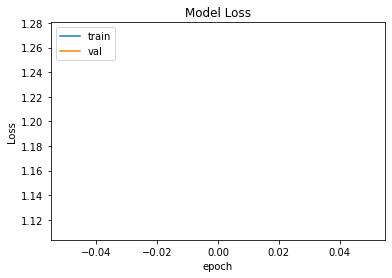


Result:
9/9 [==============================] - 0s 20ms/step - loss: 1.0304 - categorical_accuracy: 0.6679 - precision: 0.5951 - recall: 0.2717 - f1: 0.5488
Result: 'Favor':
2/2 [==============================] - 2s 21ms/step - loss: 1.4414 - categorical_accuracy: 0.0000e+00 - precision: 0.5689 - recall: 0.2850 - f1: 0.0000e+00
Result: 'Against':
6/6 [==============================] - 0s 21ms/step - loss: 0.8347 - categorical_accuracy: 0.9577 - precision: 0.6164 - recall: 0.3195 - f1: 0.8051
Result: 'Neither':
2/2 [==============================] - 0s 19ms/step - loss: 1.4321 - categorical_accuracy: 0.1333 - precision: 0.6408 - recall: 0.3357 - f1: 0.0000e+00
####################################################################################################

####################################################################################################
Performance of atheism
#########################


100%|██████████| 2926/2926 [00:00<00:00, 315692.18it/s]


5/5 [==============================] - 12s 676ms/step - loss: 1.2664 - categorical_accuracy: 0.5206 - precision: 0.6349 - recall: 0.3012 - f1: 0.3172 - val_loss: 1.1232 - val_categorical_accuracy: 0.5962 - val_precision: 0.6264 - val_recall: 0.3244 - val_f1: 0.5962


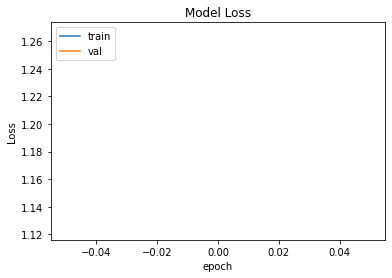


Result:
7/7 [==============================] - 0s 20ms/step - loss: 0.9775 - categorical_accuracy: 0.7273 - precision: 0.6475 - recall: 0.3565 - f1: 0.7251
Result: 'Favor':
1/1 [==============================] - 2s 2s/step - loss: 2.0228 - categorical_accuracy: 0.0000e+00 - precision: 0.6283 - recall: 0.3640 - f1: 0.0000e+00
Result: 'Against':
5/5 [==============================] - 0s 21ms/step - loss: 0.6518 - categorical_accuracy: 1.0000 - precision: 0.6565 - recall: 0.3932 - f1: 1.0000
Result: 'Neither':
1/1 [==============================] - 2s 2s/step - loss: 1.6443 - categorical_accuracy: 0.0000e+00 - precision: 0.6597 - recall: 0.4063 - f1: 0.0000e+00


100%|██████████| 2629/2629 [00:00<00:00, 279975.25it/s]

####################################################################################################

####################################################################################################
Performance of climate
#########################


4/4 [==============================] - 12s 866ms/step - loss: 1.2249 - categorical_accuracy: 0.4986 - precision: 0.6522 - recall: 0.3795 - f1: 0.2299 - val_loss: 1.0541 - val_categorical_accuracy: 0.5250 - val_precision: 0.6377 - val_recall: 0.3807 - val_f1: 0.5316


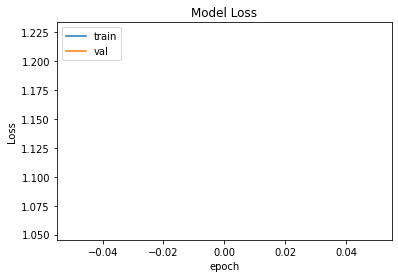


Result:
6/6 [==============================] - 0s 19ms/step - loss: 1.0620 - categorical_accuracy: 0.7278 - precision: 0.6453 - recall: 0.3940 - f1: 0.7049
Result: 'Favor':
4/4 [==============================] - 2s 21ms/step - loss: 0.8572 - categorical_accuracy: 1.0000 - precision: 0.6621 - recall: 0.4152 - f1: 0.9757
Result: 'Against':
1/1 [==============================] - 0s 34ms/step - loss: 3.4962 - categorical_accuracy: 0.0000e+00 - precision: 0.6661 - recall: 0.4221 - f1: 0.0000e+00
Result: 'Neither':
2/2 [==============================] - 0s 31ms/step - loss: 1.0166 - categorical_accuracy: 0.0000e+00 - precision: 0.6556 - recall: 0.4173 - f1: 0.0000e+00
####################################################################################################

####################################################################################################
Performance of feminist
#########################


100%|██████████| 3404/3404 [00:00<00:00, 271454.31it/s]


6/6 [==============================] - 11s 571ms/step - loss: 1.2819 - categorical_accuracy: 0.4606 - precision: 0.6499 - recall: 0.3851 - f1: 0.1858 - val_loss: 1.1962 - val_categorical_accuracy: 0.4925 - val_precision: 0.6434 - val_recall: 0.3677 - val_f1: 0.0000e+00


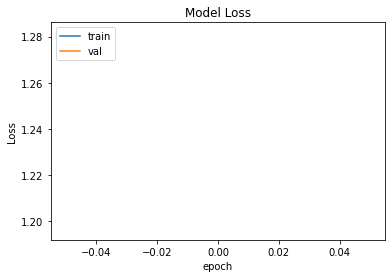


Result:
9/9 [==============================] - 0s 21ms/step - loss: 1.1421 - categorical_accuracy: 0.6386 - precision: 0.6434 - recall: 0.3521 - f1: 0.0000e+00
Result: 'Favor':
2/2 [==============================] - 2s 25ms/step - loss: 1.2788 - categorical_accuracy: 0.0000e+00 - precision: 0.6434 - recall: 0.3365 - f1: 0.0000e+00
Result: 'Against':
6/6 [==============================] - 0s 25ms/step - loss: 1.0228 - categorical_accuracy: 0.9945 - precision: 0.6434 - recall: 0.3262 - f1: 0.0000e+00
Result: 'Neither':
2/2 [==============================] - 0s 20ms/step - loss: 1.4577 - categorical_accuracy: 0.0000e+00 - precision: 0.6434 - recall: 0.3174 - f1: 0.0000e+00
####################################################################################################

####################################################################################################
Performance of hillary
#########################


100%|██████████| 3236/3236 [00:00<00:00, 310397.87it/s]


7/7 [==============================] - 11s 496ms/step - loss: 1.2742 - categorical_accuracy: 0.5290 - precision: 0.6394 - recall: 0.3066 - f1: 0.2609 - val_loss: 1.1272 - val_categorical_accuracy: 0.5652 - val_precision: 0.6356 - val_recall: 0.3067 - val_f1: 0.5693


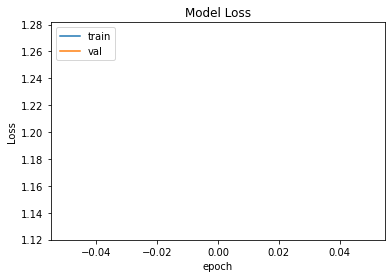


Result:
10/10 [==============================] - 0s 21ms/step - loss: 1.0922 - categorical_accuracy: 0.5831 - precision: 0.6330 - recall: 0.3164 - f1: 0.5617
Result: 'Favor':
2/2 [==============================] - 2s 20ms/step - loss: 2.1475 - categorical_accuracy: 0.0000e+00 - precision: 0.6215 - recall: 0.3202 - f1: 0.0000e+00
Result: 'Against':
6/6 [==============================] - 0s 20ms/step - loss: 0.6425 - categorical_accuracy: 1.0000 - precision: 0.6348 - recall: 0.3338 - f1: 1.0000
Result: 'Neither':
3/3 [==============================] - 0s 20ms/step - loss: 1.4749 - categorical_accuracy: 0.0000e+00 - precision: 0.6309 - recall: 0.3381 - f1: 0.0000e+00
####################################################################################################


In [ ]:
for i in all_list.keys():
  tf.keras.backend.clear_session()
  print('')
  print("#"*100)
  print("Performance of " + i)
  print("#"*25)

  #print("Data Preprocessing...")
  x_train_encoded, vocab_size, word_index_item, padded_docs_t, padded_docs_v=data_normalize(data_dict_cleaned[all_list[i][3]],data_dict_cleaned[all_list[i][2]],
                                         data_dict_cleaned[all_list[i][1]],data_dict_cleaned[all_list[i][0]],
                                         data_dict_cleaned[all_list[i][5]],data_dict_cleaned[all_list[i][4]])
  
  # SPLIT TEST DATA INTO: 'positive', 'negative' and 'neither'
  neg = tf.constant([0,1,0])
  pos = tf.constant([0,0,1])
  neither = tf.constant([1,0,0])

  positive_text = []
  positive_labels = []
  negative_text = []
  negative_labels = []
  neither_text = []
  neither_labels = []

  temp = i 
  for i, x in enumerate(data_dict_onehot[all_list[i][0]]):
    if tf.reduce_all(tf.math.equal(x,neg)):
      negative_text.append(np.ndarray.tolist(padded_docs_t[i]))
      negative_labels.append(np.ndarray.tolist(x))
    if tf.reduce_all(tf.math.equal(x,pos)):
      positive_text.append(np.ndarray.tolist(padded_docs_t[i]))
      positive_labels.append(x)
    if tf.reduce_all(tf.math.equal(x,neither)):
      neither_text.append(np.ndarray.tolist(padded_docs_t[i]))
      neither_labels.append(x)
      
  i = temp
  x_negative = np.asarray(negative_text)
  y_negative = np.asarray(negative_labels)

  x_positive = np.asarray(positive_text)
  y_positive = np.asarray(positive_labels)

  x_neither = np.asarray(neither_text)
  y_neither = np.asarray(neither_labels)

  #print("Word_embedding...")
  embedding_matrix = glove_embedding(vocab_size,word_index_item,embedding_vector)

  #print("Model building...")
  model_final=model_build(vocab_size, embedding_matrix)

  #print("Model compiling...")
  model_compile(METRICS, model_final)
  
  #print("Model training...")
  model_train(x_train_encoded, data_dict_onehot[all_list[i][2]], padded_docs_v, data_dict_onehot[all_list[i][4]], model_final)

  print('')
  print("Result:")
  evaluation(padded_docs_t, data_dict_onehot[all_list[i][0]], model_final)
  
  print("Result: 'Favor':")
  evaluation(x_positive, y_positive, model_final) #？
  
  print("Result: 'Against':")
  evaluation(x_negative, y_negative, model_final)

  print("Result: 'Neither':")
  evaluation(x_neither, y_neither, model_final)
  print("#"*100)

### #One-Classifier (Training with train data contains combined-topics)

In [ ]:
for i in all_list.keys():
  x_train=[]
  x_test=[]
  x_val=[]
  x_train.extend(data_dict_cleaned[all_list[i][3]])
  x_test.extend(data_dict_cleaned[all_list[i][1]])
  x_val.extend(data_dict_cleaned[all_list[i][5]])

  y_train=[]
  y_test=[]
  y_val=[]
  y_train.extend(data_dict_cleaned[all_list[i][2]])
  y_test.extend(data_dict_cleaned[all_list[i][0]])
  y_val.extend(data_dict_cleaned[all_list[i][4]])

  y_train_onehot=[]
  y_test_onehot=[]
  y_val_onehot=[]
  y_train_onehot.append(data_dict_onehot[all_list[i][2]])
  y_test_onehot.append(data_dict_onehot[all_list[i][0]])
  y_val_onehot.append(data_dict_onehot[all_list[i][4]])

print(x_train)

tf.keras.backend.clear_session()
print('')
print("#"*100)
print("Performance when training with combined topics")
print("#"*25)

#print("Data Preprocessing...")
x_train_encoded, vocab_size, word_index_item, padded_docs_t, padded_docs_v=data_normalize(x_train,y_train,
                                        x_test,y_test,
                                        x_val,y_val)

# SPLIT TEST DATA INTO: 'positive', 'negative' and 'neither'
neg = tf.constant([0,1,0])
pos = tf.constant([0,0,1])
neither = tf.constant([1,0,0])

positive_text = []
positive_labels = []
negative_text = []
negative_labels = []
neither_text = []
neither_labels = []

temp = i 
for i, x in enumerate(y_test_onehot[0]):
  if tf.reduce_all(tf.math.equal(x,neg)):
    negative_text.append(np.ndarray.tolist(padded_docs_t[i]))
    negative_labels.append(np.ndarray.tolist(x))
  elif tf.reduce_all(tf.math.equal(x,pos)):
    positive_text.append(np.ndarray.tolist(padded_docs_t[i]))
    positive_labels.append(x)
  elif tf.reduce_all(tf.math.equal(x,neither)):
    neither_text.append(np.ndarray.tolist(padded_docs_t[i]))
    neither_labels.append(x)


i = temp
x_negative = np.asarray(negative_text)
y_negative = np.asarray(negative_labels)

x_positive = np.asarray(positive_text)
y_positive = np.asarray(positive_labels)

x_neither = np.asarray(neither_text)
y_neither = np.asarray(neither_labels)



#print("Word_embedding...")
embedding_matrix = glove_embedding(vocab_size,word_index_item,embedding_vector)

#print("Model building...")
model_final=model_build(vocab_size, embedding_matrix)

#print("Model compiling...")
model_compile(METRICS, model_final)

print("Model training...")
model_train(x_train_encoded, y_train_onehot, padded_docs_v, y_val_onehot, model_final)

print('')
print("Result:")
evaluation(padded_docs_t, y_test_onehot, model_final)

print("Result: 'Favor':")
evaluation(x_positive, y_positive, model_final)

print("Result: 'Against':")
evaluation(x_negative, y_negative, model_final)

print("Result: 'Neither':")
evaluation(x_neither, y_neither, model_final)
print("#"*100)

In [ ]:
#Plot model
from tensorflow.keras.utils import plot_model
plot_model(model_final, to_file='model.png')


# Error Analysis

## Error Analysis-1

   Aiming at the problem of stance detection, we have implemented two models to solve this problem.
First, we used the Sklearn library to implement the SVM model as our baseline model, including the Unigram and N-gram versions.In addition, we also implemented the BILSTM + Attention model under the Keras framework.For the code itself, we did the following analysis, including some non-bug analysis, some analysis to help improve the performance of the model and some work to be done.

### Non-bug Analysis

1. For the code of data retrieval module, too many file name variables are set, which makes the code look not very concise.We recommend that you keep file names in a single list
2. There are some lines in the SVM Baseline module that are too long to conform to the code specification

### Improve the performance of the model

1. In the BiLSTM + Attention module, SGD was initially used as Optim, and perhaps Adam could be used to provide a more stable gradient descent
2. The epoch times of training can be appropriately increased, but it should be determined according to the size of each data set to prevent over-fitting

###  To be done

1. In the SVM module, the experimental results of accuracy of each data set are calculated.However, the experimental results in the original paper were not evaluated by accuracy
2. In addition, in the BiLSTM + Attention module, only experimental results under one data set have been provided so far, and experimental results of other data sets still need to be supplemented

## Error Analysis-2

### No-Bug Analysis

1. In the part of the Bilstm-Attn results show, the statement of the text is too long, resulting in a poor look.
2. In the part of the Bilstm-Attn results show, show too much things like [0,0,1] making the results intuitive

### Improve the performance of the model

1. On multiple data sets, the BILSTM model appears overfitting phenomenon.The reason for our analysis may be that the data set itself has less data, and the model is relatively complex, which is prone to over-fitting and instability of the results.My suggestion is to appropriately reduce the data proportion of the training set and increase the proportion of the verification set.

## Overall

1. The performance of the SVM model we implemented on each data set is almost better than the result in the paper, because we used Sklearn, which is a tool library that has been continuously optimized, and its computing power is better than that in 2016, so there will be some improvement.
2. As mentioned above, a proper adjustment of the BiLSTM-Attn model and data may avoid overfitting and improve the result of the model

In [ ]:
'''
x = "abortion_test_labels"
print("NEGATIVE:")
print(data_dict_onehot[x][indice_dict_neg[x][0]])
print(indice_dict_neg[x][0])

print("POSITIVE:")
print(data_dict_onehot[x][indice_dict_pos[x][0]])
print(indice_dict_pos[x][0])


print("NEITHER:")
print(data_dict_onehot[x][indice_dict_neither[x][0]])
print(indice_dict_neither[x][0])
'''